In [ ]:
import tensorflow as tf

from tensorflow.keras.datasets import mnist, cifar10, cifar100
import tensorflow.keras.layers as L
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import numpy as np
import random

from PIL import Image
from random import randint
import time
import datetime
import os

import matplotlib.pyplot as plt

tf.__version__

'2.8.2'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATASET = 'cifar'

In [ ]:
# Utility functions
def print_shapes(x_train, x_test, y_train, y_test):
  print(f"x_train: {x_train.shape}\n"\
      f"x_test: {x_test.shape}\n"\
      f"y_train: {y_train.shape}\n"\
      f"y_test: {y_test.shape}\n")

In [ ]:
# loading the dataset
if DATASET == 'mnist':
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
else:
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  
print_shapes(x_train, x_test, y_train, y_test)

x_train: (50000, 32, 32, 3)
x_test: (10000, 32, 32, 3)
y_train: (50000, 1)
y_test: (10000, 1)



In [ ]:
# Cifar100
labels = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
                'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
                'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
                'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
                'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
                'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
                'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
                'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
                'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
                'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
                'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
                'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
                'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
                'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
                'worm']

# Cifar10
#labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# MNIST
#labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']



In [ ]:
# Pre-process data
if DATASET == 'mnist':
  img_rows, img_cols, channels =  28, 28, 1 
else:
  img_rows, img_cols, channels =  32, 32, 3

num_classes = len(labels)

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape((-1, img_rows, img_cols, channels))
x_test = x_test.reshape((-1, img_rows, img_cols, channels))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print("Data shapes", x_test.shape, y_test.shape, x_train.shape, y_train.shape)



Data shapes (10000, 32, 32, 3) (10000, 100) (50000, 32, 32, 3) (50000, 100)


In [ ]:
class MyCNN(Sequential):
  def __init__(self,input_size,filter_size=128, kernel_size = (3,3), dropout_flg = True, dropout_rate = 0.3):
    super(MyCNN, self).__init__()
    self.input_size = input_size
    self.filter_size = filter_size
    self.kernel_size = kernel_size
    self.dropout_flg = dropout_flg
    self.dropout_rate = dropout_rate

    self.add(L.Conv2D(self.filter_size, kernel_size=self.kernel_size,padding='same', activation='relu', input_shape=self.input_size))
    if dropout_flg:
      self.add(L.Dropout(self.dropout_rate))
    self.add(L.MaxPooling2D(pool_size=(2, 2)))

    self.add(L.Conv2D(self.filter_size/2, kernel_size=self.kernel_size,padding='same', activation='relu',input_shape=self.input_size))
    if dropout_flg:
      self.add(L.Dropout(self.dropout_rate))
    self.add(L.MaxPooling2D(pool_size=(2, 2)))

    self.add(L.Conv2D(self.filter_size/2, kernel_size=self.kernel_size,padding='same', activation='relu'))
    if dropout_flg:
      self.add(L.Dropout(self.dropout_rate))
    self.add(L.MaxPooling2D(pool_size=(2, 2)))

    self.add(L.Conv2D(self.filter_size/2, kernel_size=self.kernel_size,padding='same', activation='relu'))
    self.add(L.MaxPooling2D(pool_size=(2, 2)))

    if dropout_flg:
      self.add(L.Dropout(self.dropout_rate))
      
    self.add(L.Flatten())
    self.add(L.Dense(32))
    self.add(L.Dropout(0.2))
    self.add(L.Dense(num_classes, activation='softmax'))

In [ ]:
# Create and fit model
model = MyCNN((img_rows, img_cols, channels))

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "my_cnn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 128)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        73792     
                                                                 
 dropout_6 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                      

In [ ]:
train_history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=8,
          validation_data=(x_test, y_test))

Epoch 1/8
391/391 [==============================] - 367s 937ms/step - loss: 0.0081 - accuracy: 0.2958 - val_loss: 0.0076 - val_accuracy: 0.4683
Epoch 2/8
391/391 [==============================] - 370s 946ms/step - loss: 0.0066 - accuracy: 0.4736 - val_loss: 0.0066 - val_accuracy: 0.5494
Epoch 3/8
391/391 [==============================] - 369s 944ms/step - loss: 0.0059 - accuracy: 0.5437 - val_loss: 0.0062 - val_accuracy: 0.5935
Epoch 4/8
391/391 [==============================] - 366s 936ms/step - loss: 0.0054 - accuracy: 0.5877 - val_loss: 0.0057 - val_accuracy: 0.6206
Epoch 5/8
391/391 [==============================] - 368s 941ms/step - loss: 0.0051 - accuracy: 0.6145 - val_loss: 0.0054 - val_accuracy: 0.6452
Epoch 6/8
391/391 [==============================] - 368s 942ms/step - loss: 0.0048 - accuracy: 0.6424 - val_loss: 0.0051 - val_accuracy: 0.6730
Epoch 7/8
391/391 [==============================] - 375s 960ms/step - loss: 0.0045 - accuracy: 0.6641 - val_loss: 0.0050 - val_ac

In [ ]:
def _plot(history = train_history):
  fig, axis = plt.subplots(2, 2,figsize=(20, 8))
  # plotting loss
  axis[0,0].plot(train_history.history['loss'], label="loss",color='red')
  axis[0, 0].set_title("Loss per epoch for training set")
  axis[0,1].plot(train_history.history['val_loss'], label="val_loss",color='red')
  axis[0, 1].set_title("Loss per epoch for validation set")
  # plotting accuracy
  axis[1,0].plot(train_history.history['accuracy'], label="accuracy",color='green')
  axis[1, 0].set_title("Accuracy per epoch for training set")
  axis[1,1].plot(train_history.history['val_accuracy'], label="val_accuracy",color='green')
  axis[1, 1].set_title("Accuracy per epoch for validation set")

  plt.show()

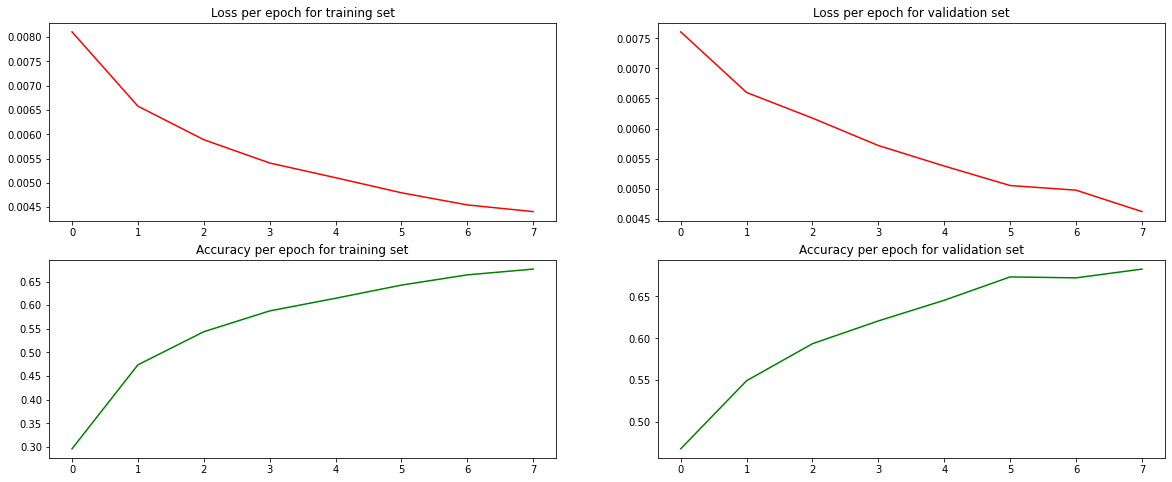

In [ ]:
_plot()

In [ ]:
# Assess base model accuracy on regular images
print("Base accuracy on regular images:", model.evaluate(x=x_test, y=y_test, verbose=0))

Base accuracy on regular images: [0.004616760183125734, 0.6822999715805054]


In [ ]:
folder_id = time.strftime('[%d%m%Y]_%H%M%s', time.localtime())
dir_path = "/content/drive/MyDrive/Thesis_notebooks/keras_boundary_attack/images"
os.mkdir(os.path.join(dir_path, folder_id))

In [ ]:
def process_img(image,adversarial_label,squeeze = False, folder = folder_id):
  """Export image file."""
  label = adversarial_label
  print("Labeling from function",label)
  
  cmap = plt.cm.jet
  id_no = time.strftime('%Y%m%d_%H%M%S', datetime.datetime.now().timetuple())
  if DATASET == 'mnist':
    norm = plt.Normalize(vmin=image.reshape((img_rows, img_cols)).min(), vmax=image.reshape((img_rows, img_cols)).max())
    # map the normalized data to colors
    # image is now RGBA (512x512x4) 
    _image = cmap(norm(image.reshape((img_rows, img_cols))))
    # Save with predicted label for image (may not be adversarial due to uint8 conversion)
    plt.imsave(os.path.join("/content/drive/MyDrive/Thesis_notebooks/keras_boundary_attack/images", folder,"{}_{}.png".format(id_no, label)), _image)

  else:
    plt.figure(figsize=(3,3))
    _image = (1/(2*1.050000000745058)) * image + 0.35
    print(np.max(image))
    plt.imsave(os.path.join("/content/drive/MyDrive/Thesis_notebooks/keras_boundary_attack/images", folder,"{}_{}.png".format(id_no, label)),_image.reshape(img_rows, img_cols, channels))

In [ ]:
def clip_eps(tensor, eps):
	# clip the values of the tensor to a given range and return it
	return tf.clip_by_value(tensor, clip_value_min=-eps,clip_value_max=eps)

In [ ]:
EPS = 2 / 255.0
LR = 0.1
optimizer = Adam(learning_rate=LR)
sccLoss = SparseCategoricalCrossentropy()
losses_per_image = []

In [ ]:
def generate_adversaries(model, baseImage, label, epochs=50):
  
  # iterate over the number of steps
  for step in range(0, epochs):
    baseImage = tf.cast(baseImage, tf.float32)
    delta = tf.Variable(tf.zeros_like(baseImage), trainable=True)
    # explicitly indicate that our perturbation vector should
 		# be tracked for gradient updates
    with tf.GradientTape() as tape:
      tape.watch(baseImage)
      # add our perturbation vector to the base image
      adversary = baseImage + delta
      # run this newly constructed image tensor through our
 			# model and calculate the loss
      pred = model(adversary)
      loss = tf.keras.losses.MSE(label, pred)
      # if step % 5 == 0:
      #    print("step: {}, loss: {}...".format(step,loss[0])) 

    # update the weights, clip the perturbation vector, and
 		# update its value
    gradients = tape.gradient(loss, baseImage)
    delta.assign_add(clip_eps(delta, eps = EPS))
    optimizer.apply_gradients([(gradients,delta)])
    signed_grad = tf.sign(gradients)

  losses_per_image.append(loss[0])
  return signed_grad


In [ ]:
# Create a signle adversarial example
rand_idx = randint(0,49999)
print(rand_idx)
image = x_train[rand_idx]
image_label = y_train[rand_idx]

baseImage = tf.constant(image, dtype=tf.float32)
delta = tf.Variable(tf.zeros_like(baseImage), trainable=True)

print("[INFO] generating perturbation...")
deltaUpdated = generate_adversaries(model, image.reshape((1, img_rows, img_cols, channels)),image_label).numpy()

#perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), image_label).numpy()
adversarial = image + deltaUpdated * 0.05

print(labels[model.predict(image.reshape((1, img_rows, img_cols, channels))).argmax()])
print(labels[model.predict(adversarial).argmax()])

if channels == 1:
    process_img(adversarial.reshape((img_rows, img_cols)),labels[model.predict(adversarial).argmax()])
else:
    #plt.imshow(adversarial.reshape((img_rows, img_cols, channels)))
    if DATASET== 'mnist':
      process_img(adversarial.reshape((img_rows, img_cols, channels)),labels[model.predict(adversarial).argmax()])
    else:
      process_img(adversarial,labels[model.predict(adversarial).argmax()])


39792
[INFO] generating perturbation...
apple
beaver
Labeling from function beaver
1.050000000745058


<Figure size 216x216 with 0 Axes>

In [ ]:
# import random

# rand_idx = 31797#random.randint(0,49999)
# _image = x_train[rand_idx]
# image_label = y_train[rand_idx]
# print(rand_idx)
# if DATASET == 'mnist':
#   process_img(_image.reshape((img_rows, img_cols, channels)), image_label)
# else:
#   process_img(_image,image_label)

In [ ]:
# rand_idx = randint(0,49999)
# image = x_train[rand_idx].reshape((1, img_rows, img_cols, channels))
# label = y_train[rand_idx]

# print(f'Prediction from CNN: {labels[np.where(image_label==1)[0][0]]}')
# plt.figure(figsize=(3,3))
# if DATASET == 'mnist':
#   plt.imsave('test.png',image.reshape((img_rows, img_cols, channels)))
# plt.show()

In [ ]:
# # Comparing both images 
# fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True)
# ax1.imshow(image.reshape(img_rows, img_cols, channels))
# ax1.set_title("Original Image")
# ax2.imshow(adversarial.reshape(img_rows, img_cols, channels))
# ax2.set_title("Image with Adversary")
# plt.show()

In [ ]:
ctr_non_misclassified = 0
ctr_misclassified = 0

In [ ]:
# Adversarial data generator
def generate_adversarials(model, batch_size, stats = False):
    while True:
        x = []
        y = []
        true_images = []
        for batch in range(batch_size):
            N = random.randint(0, 100)

            label = y_train[N]
            image = x_train[N]
            true_images.append(image)

            perturbations = generate_adversaries(model, image.reshape((1, img_rows, img_cols, channels)), label).numpy()
            
            
            epsilon = 0.1
            adversarial = image + perturbations * epsilon
            
            x.append(adversarial)
            y.append(y_train[N])
        
        
        x = np.asarray(x).reshape((batch_size, img_rows, img_cols, channels))
        y = np.asarray(y) #labels
        true_images = np.asarray(true_images).reshape((batch_size, img_rows, img_cols, channels))
        
        if stats:
          adversarials, correct_labels = x, y
          for adversarial, correct_label, image in zip(adversarials, correct_labels, true_images):
              print('Prediction:', labels[model.predict(adversarial.reshape((1, img_rows, img_cols, channels))).argmax()], 'Truth:', labels[correct_label.argmax()])
              if channels == 1:
                  tmp_label = labels[model.predict(adversarial.reshape((1, img_rows, img_cols, channels))).argmax()]
              else:
                  tmp_label = labels[model.predict(adversarial.reshape((1, img_rows, img_cols, channels))).argmax()]
              
              if tmp_label == labels[correct_label.argmax()]:
                ctr_non_misclassified += 1
              else:
                ctr_misclassified += 1

        yield x, y, true_images

Prediction: beaver Truth: bear
Labeling from function beaver
0.9549019622744298


<Figure size 216x216 with 0 Axes>

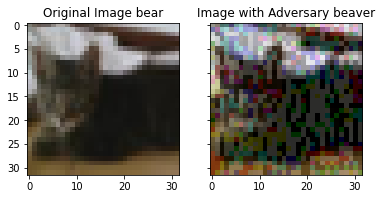

Prediction: beetle Truth: aquarium_fish
Labeling from function beetle
1.0725490210979594


<Figure size 216x216 with 0 Axes>

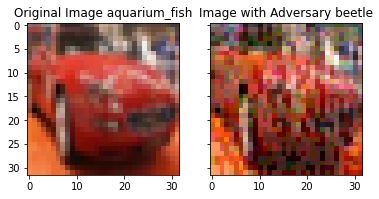

Prediction: beaver Truth: baby
Labeling from function beaver
1.0764705897254103


<Figure size 216x216 with 0 Axes>

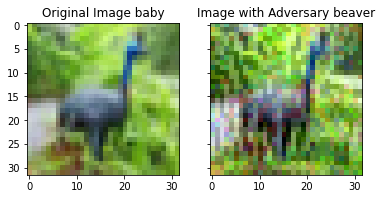

Prediction: bee Truth: bottle
Labeling from function bee
1.1000000014901161


<Figure size 216x216 with 0 Axes>

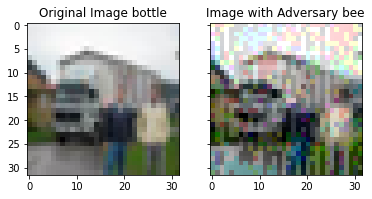

Prediction: beaver Truth: baby
Labeling from function beaver
1.0764705897254103


<Figure size 216x216 with 0 Axes>

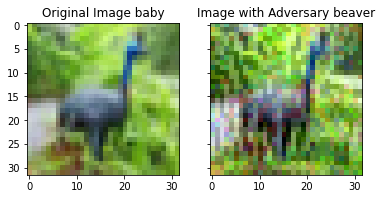

Prediction: bear Truth: apple
Labeling from function bear
1.1000000014901161


<Figure size 216x216 with 0 Axes>

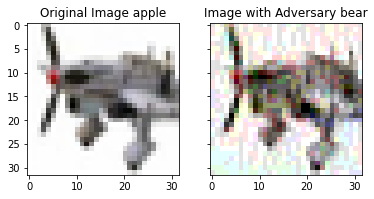

Prediction: beaver Truth: bear
Labeling from function beaver
0.9823529426665867


<Figure size 216x216 with 0 Axes>

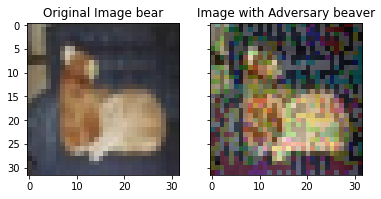

Prediction: bottle Truth: aquarium_fish
Labeling from function bottle
1.0960784328626652


<Figure size 216x216 with 0 Axes>

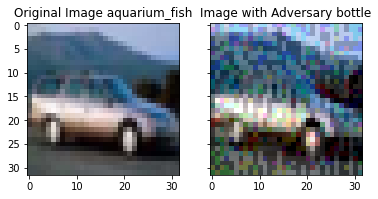

Prediction: beaver Truth: beetle
Labeling from function beaver
1.0960784328626652


<Figure size 216x216 with 0 Axes>

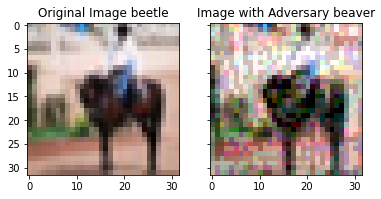

Prediction: bee Truth: beetle
Labeling from function bee
0.9862745112940376


<Figure size 216x216 with 0 Axes>

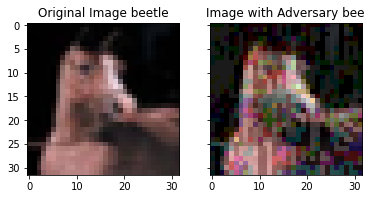

Prediction: beaver Truth: bee
Labeling from function beaver
0.9941176485489397


<Figure size 216x216 with 0 Axes>

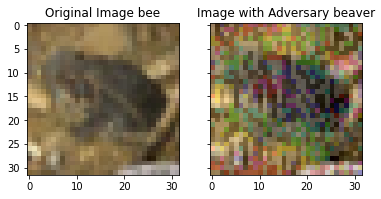

Prediction: apple Truth: aquarium_fish
Labeling from function apple
1.1000000014901161


<Figure size 216x216 with 0 Axes>

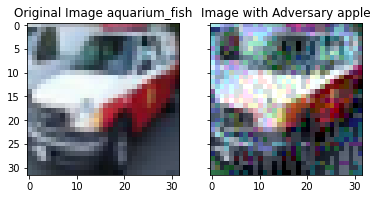

Prediction: bee Truth: bed
Labeling from function bee
1.0960784328626652


<Figure size 216x216 with 0 Axes>

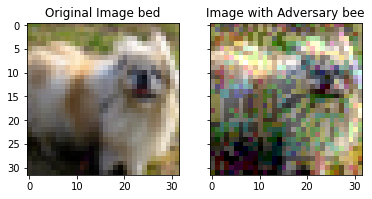

Prediction: bee Truth: bed
Labeling from function bee
1.1000000014901161


<Figure size 216x216 with 0 Axes>

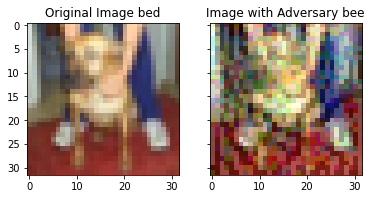

Prediction: bicycle Truth: aquarium_fish
Labeling from function bicycle
1.0764705897254103


<Figure size 216x216 with 0 Axes>

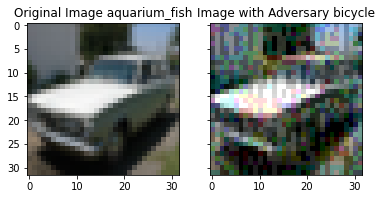

Prediction: beaver Truth: apple
Labeling from function beaver
1.0803921583528613


<Figure size 216x216 with 0 Axes>

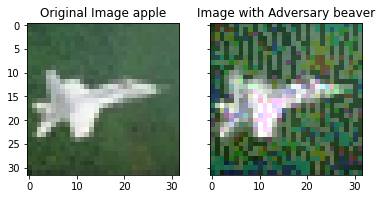

Prediction: bee Truth: aquarium_fish
Labeling from function bee
1.0960784328626652


<Figure size 216x216 with 0 Axes>

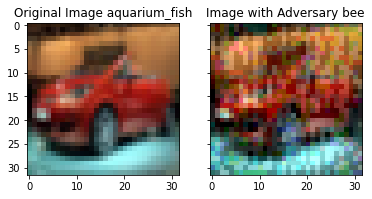

Prediction: beaver Truth: baby
Labeling from function beaver
1.0607843152156065


<Figure size 216x216 with 0 Axes>

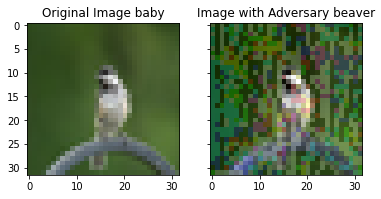

Prediction: beaver Truth: beetle
Labeling from function beaver
1.0725490210979594


<Figure size 216x216 with 0 Axes>

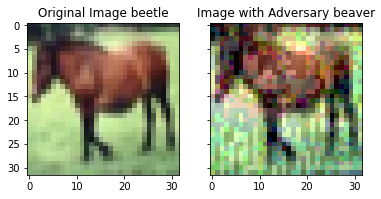

Prediction: beaver Truth: bee
Labeling from function beaver
1.1000000014901161


<Figure size 216x216 with 0 Axes>

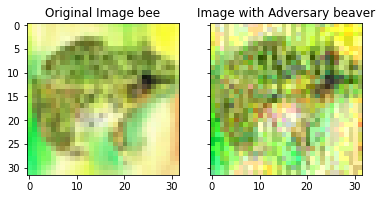

In [ ]:
# Generate and visualize 12 adversarial images
adversarials, correct_labels, true_images = next(generate_adversarials(model,20))
for adversarial, correct_label, image in zip(adversarials, correct_labels, true_images):
    print('Prediction:', labels[model.predict(adversarial.reshape((1, img_rows, img_cols, channels))).argmax()], 'Truth:', labels[correct_label.argmax()])
    if channels == 1:
        tmp_label = labels[model.predict(adversarial.reshape((1, img_rows, img_cols, channels))).argmax()]
        process_img(image.reshape(img_rows, img_cols, channels),labels[correct_label.argmax()])
        process_img(adversarial.reshape((img_rows, img_cols)),tmp_label)
        #plt.imshow(adversarial.reshape(img_rows, img_cols))
    else:
        tmp_label = labels[model.predict(adversarial.reshape((1, img_rows, img_cols, channels))).argmax()]
        process_img(adversarial,tmp_label)
        #plt.imshow(adversarial)

        fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True)
        ax1.imshow(image.reshape(img_rows, img_cols, channels))
        ax1.set_title("Original Image "+labels[correct_label.argmax()])
        ax2.imshow(adversarial.reshape(img_rows, img_cols, channels))
        ax2.set_title("Image with Adversary "+tmp_label)
    plt.show()

In [ ]:
# Generate adversarial data
# x_adversarial, y_adversarial = np.load("x_adv_10k.npy"), np.load("y_adv_10k.npy")
x_adversarial_train, y_adversarial_train,_ = next(generate_adversarials(model,2000))
x_adversarial_test, y_adversarial_test,_ = next(generate_adversarials(model,1000))

In [ ]:
# Assess base model on adversarial data
print("Base accuracy on adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))

In [ ]:
# Learn from adversarial data
model.fit(x_adversarial_train, y_adversarial_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_test, y_test))


In [ ]:
# Assess defended model on adversarial data
print("Defended accuracy on adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))

# Assess defended model on regular data
print("Defended accuracy on regular images:", model.evaluate(x=x_test, y=y_test, verbose=0))

In [ ]:
x_adversarial_test, y_adversarial_test, _ = next(generate_adversarials(model, 10))
print("Defended accuracy on adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))

In [ ]:
print("Missclassified images:", ctr_misclassified)
print("Non Missclassified images:", ctr_non_misclassified)